# Libraries

## Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Built-in libraries

In [2]:
import math
import timeit
import pandas                                   as pd
import numpy                                    as np

## Keras libraries

In [3]:
from   tensorflow.keras                         import Input
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau

from   tensorflow.keras.models                  import Sequential
from   tensorflow.keras.models                  import Model
from   tensorflow.keras.layers                  import Dense
from   tensorflow.keras.layers                  import Flatten
from   tensorflow.keras.layers                  import Conv1D
from   tensorflow.keras.layers                  import Dropout
from   tensorflow.keras.layers                  import BatchNormalization
from   tensorflow.keras.optimizers              import *

## User libraries

In [4]:
from   utils.fileHandling                             import getData
from   utils.fileHandling                             import splitData
from   utils.BLAS                                     import create_dataset
from   utils.BLAS                                     import step_decay_schedule
from   utils.Evaluation                               import AutoCorrelationTest
from   utils.Evaluation                               import RegressionEvaluation
from   utils.Evaluation                               import ClassificationEvaluation
from   utils.Evaluation                               import ConfusionMatrixVisualize

## Visualization libraries

In [5]:
import matplotlib.pyplot                        as plt 
import seaborn                                  as sns

# Visualization settings
#
sns.set( rc = {'figure.figsize':(15,5)})
plt.rcParams.update({'font.size': 14})

# Parameters

In [6]:
#%%
# Parameters
SeriesName     = 'ETH'
Strategy       = 'Differenced' # Differenced, Returns

Lag            = 5 # 8, 16, 24
#
# Dates   ->     'Start Validation' 'Start Testing' 
Dates      = ['2020-02-28',     '2020-06-01']

#
# Neural network parameters
epochs         =  20
batch_size     =  8

# Data handling

## Import data

In [7]:
#%%
# Get Data
Series, Transformed_Series = getData('Data//' + SeriesName + '.csv', Strategy)


# Split data to Training, Validation and Testing sets
Training,      Validation,      Testing      = splitData(Series,             Dates)
Training_diff, Validation_diff, Testing_diff = splitData(Transformed_Series, Dates)

[INFO] Strategy: Differenced was selected


## Visualize Training, Validation and Testing Data

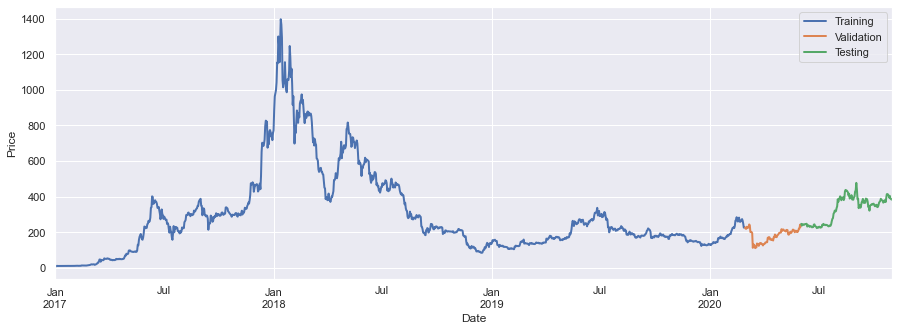

In [8]:
fig, ax = plt.subplots(figsize=(15,5));
#
#
Training[SeriesName].plot(ax=ax, linewidth=2);
Validation[SeriesName].plot(ax=ax, linewidth=2);
Testing[SeriesName].plot(ax=ax, linewidth=2);
#
ax.legend(['Training', 'Validation', 'Testing']);
ax.set_ylabel('Price');

## Fix Lags

In [9]:
# -Traditional Series
Validation      = pd.concat([Training.iloc[-Lag:],   Validation])
Testing         = pd.concat([Validation.iloc[-Lag:], Testing])


# -Differenced Series
Validation_diff = pd.concat([Training_diff.iloc[-Lag:],   Validation_diff])
Testing_diff    = pd.concat([Validation_diff.iloc[-Lag:], Testing_diff])

## Contruction of Training, Validation and Testing sets for training a forecasting model

In [10]:
trainX, trainY = create_dataset(Training_diff,   Lag, SeriesName)
validX, validY = create_dataset(Validation_diff, Lag, SeriesName)
testX,  testY  = create_dataset(Testing_diff,    Lag, SeriesName)

### Scaling data

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

trainX = np.expand_dims( scaler.fit_transform(trainX[:,:,0]), axis=-1)
validX = np.expand_dims( scaler.fit_transform(validX[:,:,0]), axis=-1)
testX  = np.expand_dims( scaler.fit_transform(testX[:,:,0]),  axis=-1)

# Forecasting model

In [12]:
model_input = Input(shape=( trainX.shape[1], trainX.shape[2]) )   


x = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu' )(model_input)
x = Flatten()(x)
#
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
  
x = Dense(1)(x)



model = Model(model_input, x)
model.compile(loss='mean_squared_error', optimizer='adam')


model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 32)             96        
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               20608     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________

In [13]:
#%%
# Checkpoint
checkpoint = ModelCheckpoint("model/model.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 10)

# Learning rate adjustment
# lrs_scheduler = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.75,
                                   patience    = 5)


## Training forecasting model

In [14]:
# Start clock
start = timeit.default_timer()

score = model.fit(trainX, trainY, 
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = 1, 
                  validation_data = (validX, validY))

# Terminate clock
stop = timeit.default_timer()

Train on 1147 samples, validate on 94 samples
Epoch 1/20
1147/1147 [==============================] - 2s 1ms/sample - loss: 576.9007 - val_loss: 158.6417
Epoch 2/20
1147/1147 [==============================] - 0s 335us/sample - loss: 557.2259 - val_loss: 164.3290
Epoch 3/20
1147/1147 [==============================] - 0s 300us/sample - loss: 550.9659 - val_loss: 166.8094
Epoch 4/20
1147/1147 [==============================] - 0s 306us/sample - loss: 546.6951 - val_loss: 169.1987
Epoch 5/20
1147/1147 [==============================] - 0s 320us/sample - loss: 546.2374 - val_loss: 172.9458
Epoch 6/20
1147/1147 [==============================] - 0s 337us/sample - loss: 532.6421 - val_loss: 176.5215
Epoch 7/20
1147/1147 [==============================] - 0s 306us/sample - loss: 527.0825 - val_loss: 179.2627
Epoch 8/20
1147/1147 [==============================] - 0s 310us/sample - loss: 529.6026 - val_loss: 174.8818
Epoch 9/20
1147/1147 [==============================] - 0s 299us/sample - lo

## Load (BEST) forecasting model

In [15]:
# Load the best model
#
model.load_weights('model/model.hdf5')

# Evaluation - Simulation results

## Get predictions


In [16]:
y_pred = model.predict(testX)[:,0]

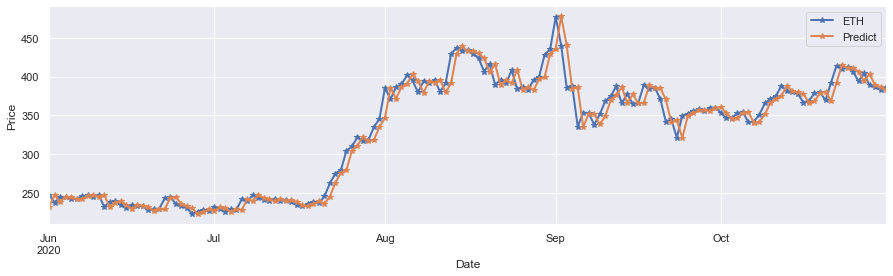

In [17]:
# Set DataFrame with 'Real' and 'Predicted' values
Prices = pd.DataFrame([], columns=[SeriesName, 'Predict'])
# Get real values

# Reverse transformation
if (Strategy == 'Differenced'):
    Prices[ SeriesName ]    = Testing[SeriesName][Lag:]
    Prices['Predict'] = Testing[SeriesName][Lag-1:-1].to_numpy() + y_pred
else:
    Prices[ SeriesName ] = np.exp( Testing[SeriesName][Lag:] )
    Prices['Predict']    = np.exp( Testing[SeriesName][Lag-1:-1].to_numpy() + y_pred )



ax = Prices.plot( figsize=(15,4), linewidth=2, marker='*')
ax.set_ylabel('Price')
plt.show()

MAE   = 9.129
RMSE  = 13.402
MAPE  = 2.658
SMAPE = 2.660
R2    = 0.965


Accuracy  = 50.66%
AUC       = 0.510
F1        = 0.522
GM        = 38.419
Sen       = 0.482
Spe       = 0.537
Spe x Sen = 0.259




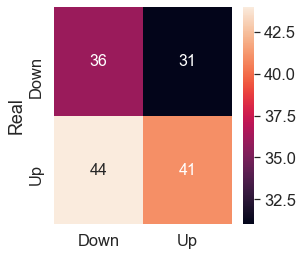

In [18]:
# Regression performance
#
MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )
#
print('MAE   = %.3f' % MAE)
print('RMSE  = %.3f' % RMSE)
print('MAPE  = %.3f' % MAPE)
print('SMAPE = %.3f' % SMAPE)
print('R2    = %.3f' % R2)
print('\n')



# Classification performance
#
CM, Accuracy, AUC, F1, GM, Sen, Spe, PPV, NPV = ClassificationEvaluation( Prices )
#
print('Accuracy  = %.2f%%' % (100*Accuracy))
print('AUC       = %.3f' % AUC)
print('F1        = %.3f' % F1)
print('GM        = %.3f' % GM)
print('Sen       = %.3f' % Sen)
print('Spe       = %.3f' % Spe)
print('Spe x Sen = %.3f' % (Sen*Spe))
print('\n')


# Confusion matrix
#
ConfusionMatrixVisualize(CM)





Ljung-Box Q-test    ***   p-value = 0.1212
H0 is REJECTED


Box-Pierce test     ***   p-value = 0.1479
H0 is REJECTED




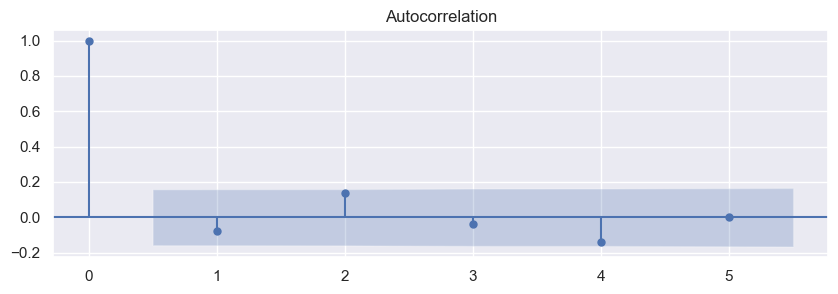

In [19]:
#%%
AutoCorrelationTest(Prices[ SeriesName ].to_numpy(), Prices['Predict'].to_numpy())